243


(-0.5, 1023.5, 341.5, -0.5)

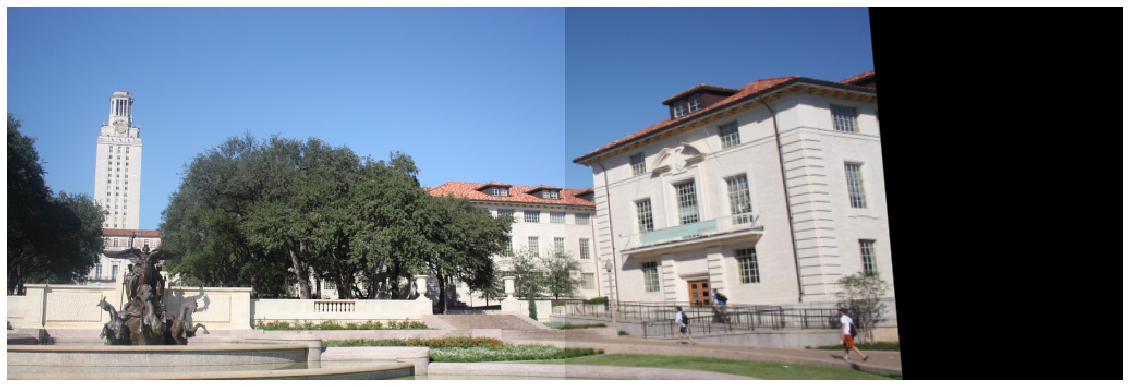

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## 테스트할 이미지
img_1 = cv2.imread('left.jpg')
img_1 = cv2.resize(img_1, None, fx=0.5, fy=0.5)
gray_1 = cv2.cvtColor(img_1,cv2.COLOR_BGR2GRAY)
img_2 = cv2.imread('right.jpg')
img_2 = cv2.resize(img_2, None, fx=0.5, fy=0.5)
gray_2 = cv2.cvtColor(img_2,cv2.COLOR_BGR2GRAY)

## 이미지 확인
#cv2.imshow('image 1', img_1)
#cv2.imshow('image 2', img_2)
#cv2.waitKey(0)

#cv2.destroyAllWindows()

## 1) 각각의 영상에서 SIFT 특징 추출
sift = cv2.xfeatures2d.SIFT_create()
kp_1, des_1 = sift.detectAndCompute(gray_1, None) #키포인트(kp_1), 특징기술자(des_1) 뽑아줌
kp_2, des_2 = sift.detectAndCompute(gray_2, None)

## 2-1) 두 영상의 지역 특징 간 거리 계산
## https://docs.opencv.org/2.4/modules/features2d/doc/common_interfaces_of_descriptor_matchers.html#bfmatcher
bf = cv2.BFMatcher()
matches = bf.knnMatch(queryDescriptors = des_1,
                      trainDescriptors = des_2,
                      k=2)   # 특징점 하나당 거리가 가까운 상위 k개의 대응점을 찾아줌

## 2-2) '최근접 거리 비율' 매칭 전략('ratio testing')을 사용하여 대응점 쌍 생성
ratio = 0.7  # 보통 0.7 ~ 0.8 값 사용
good = []    # 좋은 대응점 쌍만 따로 저장
for m,n in matches:
    if m.distance < n.distance * ratio:
        good.append(m)
        
## optional) SIFT 특징점 매칭 결과 확인하기
print(len(good))
matched = cv2.drawMatches(img1 = img_1, 
                          keypoints1 = kp_1, 
                          img2 = img_2, 
                          keypoints2 = kp_2, 
                          matches1to2 = good[:20],   # 첫 20개 매칭쌍만 시각화
                          outImg = None, 
                          flags = 2)

#cv2.imshow('matching result', matched)
#cv2.waitKey(0)

#cv2.destroyAllWindows()

## 3) RANSAC을 이용한 변환 행렬 H 추정
## 참고. cv2.getPerspectiveTransform()와 cv2.findHomography()의 차이
##   cv2.getPerspectiveTransform() - 4개의 대응점 쌍을 입력하면 변환 행렬을 반환해줌
##   cv2.findHomography() - 4개 이상의 대응점 쌍을 입력하면 가장 대응점들을 가장 잘 만족하는 변환 행렬을 반환해줌
## https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#findhomography
if len(good) >= 4:   # 4개 이상의 대응점이 존재해야 원근 변환 행렬을 추정 가능
    src_pts = np.float32([ kp_2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    H, _ = cv2.findHomography(srcPoints = src_pts, 
                              dstPoints = dst_pts, 
                              method = cv2.RANSAC, 
                              ransacReprojThreshold = 5) 
    
else:
    raise AssertionError("Can't find enough keypoints.")
    

## 4) 원근 변환 적용
## 변환 행렬 H를 사용하여 변환 수행
## https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#warpperspective

transformed = cv2.warpPerspective(img_2,H,(img_1.shape[1]+img_2.shape[1],img_1.shape[0]))
#cv2.imshow('transformed',transformed)

## 5) 두 영상을 한 장으로 이어붙이기

transformed[0:img_1.shape[0], 0:img_1.shape[1]] = img_1
res = transformed

## 결과 파노라마 영상 시각화
plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
plt.axis('off')

cv2.imshow('panorama', res)
cv2.waitKey(0)
cv2.destroyAllWindows()